# **Correlator of Lorentz force felt by heavy quarks immersed in the Glasma**

Default simulation parameters chosen for Pb-Pb at 5.02 TeV.


In [1]:
import numpy as np

"""
    Default simulation parameters chosen for Pb-Pb at 5.02 TeV
"""

# General parameters
su_group = 'su2'
folder = 'corr_pb+pb_5020gev_su2_interp_pT_0.5'

# Simulation box parameters
L = 10      # Length of simulation box [fm]
N = 512     # Number of lattice sites
tau_s = 2.0     # Simulation time [fm/c]
DTS = 8     # Time step

# MV model parameters for Pb-Pb at 5.02 TeV
A = 207     # Mass number
sqrts = 5020        # Center-of-mass energy [GeV]
ns = 50     # Number of color sheets
factor = 0.8        # Ratio between Qs/g^2\mu for Ns = 50 color sheets
Qs = np.sqrt(0.13 * A**(1/3) * sqrts**0.25)         # Saturation momentum [GeV]	
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))           # Running coupling constant		
mu = Qs / (g**2 * factor)           # MV model parameter	
m = 0.1 * g**2 * mu         # Infrared regulator [GeV]
uv = 10.0           # Ultraviolet regulator [GeV]

# Heavy quark related parameters, chosen here for a charm quark
mass = 1.5      # Heavy quark mass [GeV]
tau_form = 0.06     # Formation time [fm/c]
nq = 15     # Number of heavy quarks
pT = 0.5    # Initial transverse momentum [GeV]
ntp = 10    # Number of test particles

# Other numerical parameters
nevents = 10    # Number of Glasma events

Dictionary with standard MV model paramaters.

In [2]:
p = {
    # General parameters
    'GROUP':    su_group,       # SU(2) or SU(3) group
    'FOLDER':   folder ,         # results folder

    # Parameters for simulation box
    'L':    L,           # transverse size [fm]
    'N':    N,            # lattice size
    'DTS':  DTS,             # time steps per transverse spacing
    'TMAX': tau_s,          # max. proper time (tau) [fm/c]

    # Parameters for MV model
    'G':    g,            # YM coupling constant
    'MU':   mu,             # MV model parameter [GeV]
    'M':    m,              # IR regulator [GeV]
    'UV':   uv,           # UV regulator [GeV]
    'NS':   ns,             # number of color sheets
    
    # Parameters for heavy quarks
    'MASS': mass,           # mass of HQ [GeV]
    'TFORM': tau_form,       # formation time of the HQ [fm/c]
    'PT': pT,           # transverse momentum of HQs [GeV]
    'NQ': nq,         # number of heavy quarks
    'NTP': ntp,         # number of test particles

    # Numerical parameters
    'NEVENTS': nevents,     # number of Glasma events
}

Set environment variables.

In [3]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
if p['GROUP'] == 'su2':
    os.environ["GAUGE_GROUP"] = 'su2_complex'
    id0 = (1, 0, 0, 1)
elif p['GROUP'] == 'su3':
    os.environ["GAUGE_GROUP"] = p['GROUP']
    id0 = (1, 0, 0, 0, 1, 0, 0, 0, 1)

# Import curraun and other packages
import sys
sys.path.append('..')
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda
from curraun.wong_hq import WongFields, WongPotentials, InitialColorCharge, ColorChargeEvolve, initial_coords, initial_momenta, initial_charge, interpfield, interppotential, update_coords, update_momenta
# from curraun.wong_force_correlators import ElectroMagneticFields
from curraun.wong_force_correlators import ElectricFields, LorentzForce, ForceCorrelators

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

Using CUDA
Using SU(2) complex
Using double precision
Using double precision


Simulation function.

In [3]:
def simulate(p, xmu0, pmu0, q0, seed):    
    # Derived parameters
    a = p['L'] / p['N']
    E0 = p['N'] / p['L'] * hbarc
    p['E0'] = E0
    DT = 1.0 / p['DTS']
    maxt = int(p['TMAX'] / a * p['DTS'])
    formt = int(p['TFORM'] / a * p['DTS'])
    mass = p['MASS']

    # Normal units: x/y [fm], eta [1], px/py [GeV], peta [GeV/fm]
    # Lattice units
    x0, y0, eta0 = xmu0[0]/a, xmu0[1]/a, xmu0[2]
    ptau0, px0, py0, peta0 = pmu0[0]/E0, pmu0[1]/E0, pmu0[2]/E0, pmu0[3]*a/E0

    s = core.Simulation(p['N'], DT, p['G'])
    mv.set_seed(seed)
    va = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
    vb = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
    initial.init(s, va, vb)

    fields = WongFields(s)
    potentials = WongPotentials(s)
    charge_initial = InitialColorCharge(s)
    charge_evolve = ColorChargeEvolve(s)

    electric_fields = ElectricFields(s)
    lorentz_force = LorentzForce(s)
    force_correlators = ForceCorrelators(s)

    if use_cuda:
        s.copy_to_device()

    output = {}
    if p['GROUP']=='su3':
        tags_output = ['xmu', 'pmu', 'constraint', 'qsq', 'qcub']
    else:
        tags_output = ['xmu', 'pmu', 'constraint', 'qsq']
    for tag in tags_output:
        output[tag] = []

    tags_e, tags_f = ['static', 'naive', 'UxUy', 'UxUyAeta', 'AetaUxUy'], ['naive', 'UxUy', 'UxUyAeta', 'AetaUxUy']
    all_EformE, all_FformF = {}, {}
    for tag in tags_e:
        all_EformE[tag] = []
    for tag in tags_f:
        all_FformF[tag] = []

    for t in range(maxt):
        core.evolve_leapfrog(s)

        if t>=formt:  
            current_tau = t * DT
            tau_step = DT
            
            if t==formt:
                output['xmu'].append([a*current_tau, a*x0, a*y0, eta0])
                output['pmu'].append([E0*ptau0, E0*px0, E0*py0, E0/a*peta0])

                charge_initial.compute(p['GROUP'], q0)
                Q0 = charge_initial.Q
                Qsq0 = charge_initial.Q2[0].real
                output['qsq'].append(Qsq0)
                if p['GROUP']=='su3':
                    Qcub0 = charge_initial.Q3[0].real
                    output['qcub'].append(Qcub0)

                xhq0, yhq0 = int(round(x0)), int(round(y0))
                Eform = electric_fields.compute(xhq0, yhq0)
                Fform = lorentz_force.compute(xhq0, yhq0, ptau0, px0, py0, peta0, current_tau)

                Uxhq0, Uyhq0 = np.array(id0), np.array(id0)

            # Solve Wong's equations using basic Euler
            # Update positions
            x1, y1, eta1 = update_coords(x0, y0, eta0, ptau0, px0, py0, peta0, tau_step)
            delta_eta = eta1-eta0

            # Convert to physical units
            output['xmu'].append([a*current_tau, a*x1, a*y1, eta1])

            # Approximate the position of the quark with closest lattice point
            # Locations where transverse gauge fields extracted from gauge links are evaluated, in the middle of lattice sites
            xhq, yhq = int(round(x0)), int(round(y0))
            xahq, yahq = int(round(x0-1/2)), int(round(y0-1/2))

            fields.compute(Q0, xhq, yhq)
            trQE, trQB = fields.trQE.real, fields.trQB.real

            potentials.compute('x', xahq, yhq)
            Ax = potentials.Ax
            potentials.compute('y', xhq, yahq)
            Ay = potentials.Ay
            potentials.compute('eta', xhq, yhq)
            Aeta = potentials.Aeta

            # Update momenta using Euler, with fields evaluated at nearest lattice points
            ptau1, ptau2, px1, py1, peta1 = update_momenta(ptau0, px0, py0, peta0, tau_step, current_tau, trQE, trQB, mass, E0)

            # Convert to physical units
            output['pmu'].append([E0*ptau1, E0*px1, E0*py1, E0/a*peta1])
            output['constraint'].append(E0*(ptau2-ptau1))

            charge_evolve.compute(p['GROUP'], Q0, tau_step, ptau0, px0, py0, peta0, Ax, Ay, Aeta)
            Q1 = charge_evolve.Q
            Qsq = charge_evolve.Q2[0].real
            output['qsq'].append(Qsq)
            if p['GROUP']=='su3':
                Qcub = charge_initial.Q3[0].real
                output['qcub'].append(Qcub)

            # [(GeV / fm) ** 2]
            units = (E0 ** 2 / hbarc) ** 2 / p['G'] ** 2

            E = electric_fields.compute(xhq, yhq)
            F = lorentz_force.compute(xhq, yhq, ptau0, px0, py0, peta0, current_tau)

            # EformE = compute_correlator(force_correlators, tags_e, Eform, E, Uxhq0, Uyhq0, xhq, xhq0, yhq, yhq0, delta_eta, xmu0[1]/a, xmu0[2]/a, units)
            # FformF = compute_correlator(force_correlators, tags_f, Fform, F, Uxhq0, Uyhq0, xhq, xhq0, yhq, yhq0, delta_eta, xmu0[1]/a, xmu0[2]/a, units)

            EformE  = {}
            xhq_init, yhq_init = xmu0[1]/a, xmu0[2]/a
            for tag in tags_e:
                # Used to compute the correlator of electric fields in the initial point where the HQ is initialized, as the Glasma fields evolve
                if tag=='static':
                    force_correlators.compute('naive', Eform, E, Uxhq0, Uyhq0, xhq_init, xhq_init, yhq_init, yhq_init, delta_eta)
                    EformE[tag] = force_correlators.fformf * units
                else:
                    force_correlators.compute(tag, Eform, E, Uxhq0, Uyhq0, xhq, xhq0, yhq, yhq0, delta_eta)
                    EformE[tag] = force_correlators.fformf * units

                all_EformE[tag].append(EformE[tag])

            FformF = {}
            for tag in tags_f:
                force_correlators.compute(tag, Fform, F, Uxhq0, Uyhq0, xhq, xhq0, yhq, yhq0, delta_eta)
                FformF[tag] = force_correlators.fformf * units

                all_FformF[tag].append(FformF[tag])

            Uxhq, Uyhq = force_correlators.Uxhq, force_correlators.Uyhq

            if (xhq!=xhq0):
                xhq0=xhq
            if (yhq!=yhq0):
                yhq0=yhq

            # Swap initial x, p, Q for next time step
            x0, y0, eta0 = x1, y1, eta1
            px0, py0, peta0, ptau0 = px1, py1, peta1, ptau1
            Q0 = Q1
            Uxhq0, Uyhq0 = Uxhq, Uyhq

    output['EformE'], output['FformF'] = all_EformE, all_FformF

    if use_cuda:
        s.copy_to_host()
        cuda.current_context().deallocations.clear()

    return output

Create folders to store the files resulting from the simulations


In [4]:
import pickle

current_path = os.getcwd() 
results_folder = 'results'
check_results_folder = os.path.isdir(results_folder)
if not check_results_folder:
    os.makedirs(results_folder)
results_path = current_path + '/' + results_folder + '/'
os.chdir(results_path)

wong_folder = p['FOLDER']
check_wong_folder = os.path.isdir(wong_folder)
if not check_wong_folder:
    os.makedirs(wong_folder)
wong_path = results_path + '/' + wong_folder + '/'
os.chdir(wong_path)

# Save parameters dictionary to file
with open('parameters.pickle', 'wb') as handle:
    pickle.dump(p, handle)

Simulate multiple Glasma events, each event with 15 quarks and 15 antiquarks, produced at the same positions as the quarks, having opposite momenta and random charge. The number of quarks or antiquarks in enlarged by a given number of test particles.


In [6]:
from tqdm.notebook import tqdm

# Initializing progress bar objects
# Source: https://stackoverflow.com/questions/60928718/python-how-to-replace-tqdm-progress-bar-by-next-one-in-nested-loop
outer_loop=tqdm(range(p['NEVENTS']), desc="Event", position=0)
mid_loop=tqdm(range(p['NQ']), desc="Quark antiquark pair", position=1)
inner_loop=tqdm(range(p['NTP']), desc="Test particle", position=2)

for ev in range(len(outer_loop)):
    # Fixing the seed in a certain event
    seed = ev

    mid_loop.refresh() 
    mid_loop.reset() 
    outer_loop.update() 

    for q in range(len(mid_loop)):

        inner_loop.refresh()  
        inner_loop.reset()  
        mid_loop.update()  

        for tp in range(len(inner_loop)):
            xmu0 = initial_coords(p)
            pmu0 = initial_momenta(p)

            # Quark
            q0 = initial_charge(p)

            output = simulate(p, xmu0, pmu0, q0, seed)

            filename = 'ev_' + str(ev+1) + '_q_' + str(q+1) + '_tp_' + str(tp+1) + '.pickle'
            with open(filename, 'wb') as handle:
                pickle.dump(output, handle)

            # Antiquark having opposite momentum and random color charge
            q0 = initial_charge(p)
            pmu0 = [pmu0[0], -pmu0[1], -pmu0[2], pmu0[3]]

            output = simulate(p, xmu0, pmu0, q0, seed)

            filename = 'ev_' + str(ev+1) + '_aq_' + str(q+1) + '_tp_' + str(tp+1) + '.pickle'
            with open(filename, 'wb') as handle:
                pickle.dump(output, handle)

            inner_loop.update()  

Read the results from files and compute averages.

In [5]:
tags_e, tags_f = ['static', 'naive','UxUyAeta'], ['naive', 'UxUyAeta']
# tags_e, tags_f = ['static', 'naive', 'UxUy', 'UxUyAeta', 'AetaUxUy'], ['naive', 'UxUy', 'UxUyAeta', 'AetaUxUy']
all_EformE, all_FformF = {}, {}
for tag in tags_e:
    all_EformE[tag] = []
for tag in tags_f:
    all_FformF[tag] = []

taui=0
for file in os.listdir(wong_path):
    if not file.startswith("parameters"):
        data = pickle.load(open("./{}".format(file), "rb"))

        for tag in tags_e:
            all_EformE[tag].append(data['EformE'][tag])

        for tag in tags_f:
            all_FformF[tag].append(data['FformF'][tag])

        if taui==0:
            tau=np.array(data['xmu'])[:, 0]
            taui = taui+1
print(all_EformE['naive'])
mean_EformE, std_EformE, mean_FformF, std_FformF = {}, {}, {}, {}
for tag in tags_e:
    mean_EformE[tag], std_EformE[tag] = np.mean(all_EformE[tag], axis=0), np.std(all_EformE[tag], axis=0)
for tag in tags_f:
    mean_FformF[tag], std_FformF[tag] = np.mean(all_FformF[tag], axis=0), np.std(all_FformF[tag], axis=0)

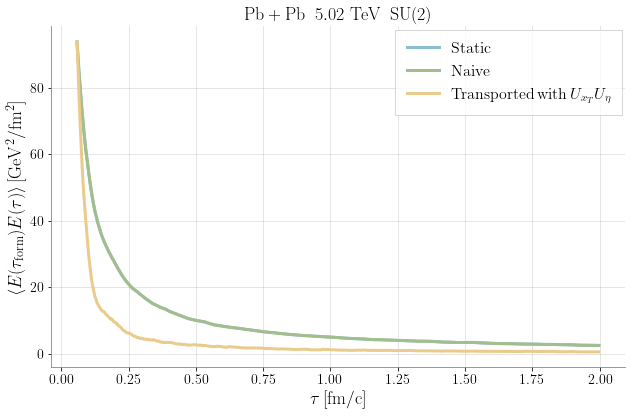

In [8]:
tags_e = ['static', 'naive','UxUyAeta']
# tags_e = ['static', 'naive', 'UxUy', 'UxUyAeta', 'AetaUxUy']

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot(111)
plt.title(r'$\mathrm{Pb+Pb}\,\,\, 5.02\,\,\mathrm{TeV}\,\,\,\mathrm{SU(2)}$', size = 18)
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 18)
plt.ylabel(r'$\langle E(\tau_\mathrm{form})E(\tau)\rangle\,\mathrm{[GeV^2/fm^2]}$', size = 18)

# ax.xaxis.set_major_locator(MultipleLocator(0.5))
# ax.xaxis.set_minor_locator(MultipleLocator(0.25))
# ax.yaxis.set_major_locator(MultipleLocator(40))
# ax.yaxis.set_minor_locator(MultipleLocator(20))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
# ax.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
# ax.yaxis.get_major_ticks()[0].label1.set_visible(False)

plt.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)

colors = ['#88C0D0', '#A3BE8C', '#EBCB8B']
labels = [r'$\mathrm{Static}$', r'$\mathrm{Naive}$', r'$\mathrm{Transported\,with\,}U_{x_T}U_\eta$']
# colors = ['#81A1C1', '#88C0D0', '#A3BE8C', '#EBCB8B', '#B48EAD']
# labels = [r'$\mathrm{Static}$', r'$\mathrm{Naive}$', r'$\mathrm{Transported\,with\,}U_{x_T}$', r'$\mathrm{Transported\,with\,}U_{x_T}U_\eta$', r'$\mathrm{Transported\,with\,}U_\eta U_{x_T}$']

i = 0
sum_mean_EformE, sum_std_EformE = {}, {}
for tag in tags_e:
    sum_mean_EformE[tag] = mean_EformE[tag][:, 0, 0] + mean_EformE[tag][:, 1, 1] + mean_EformE[tag][:, 2, 2]
    sum_std_EformE[tag] = std_EformE[tag][:, 0, 0] + std_EformE[tag][:, 1, 1] + std_EformE[tag][:, 2, 2]
    ax.plot(tau[1:len(tau)], sum_mean_EformE[tag], linestyle = 'solid', color = colors[i], markersize = 0, linewidth = 3, label = labels[i])
    # ax.fill_between(tau[1:len(tau)], sum_mean_EformE[tag]-sum_std_EformE[tag]/2, sum_mean_EformE[tag]+sum_std_EformE[tag]/2, color = colors[i], alpha=0.3)
    i = i+1

leg = ax.legend(fontsize = 16, loc = 'upper right')
leg.get_frame().set_boxstyle('square')
# leg.set_title(r'$\tau_\mathrm{form}\,\mathrm{[fm/c]}$',prop={'size':18})

plt.tight_layout()
os.chdir(current_path)
plt.savefig('corr_EE_' + su_group + '_pT_' + str(pT) +'_pb+pb_5020gev.png', dpi=300, facecolor='white', transparent=False)
plt.show()

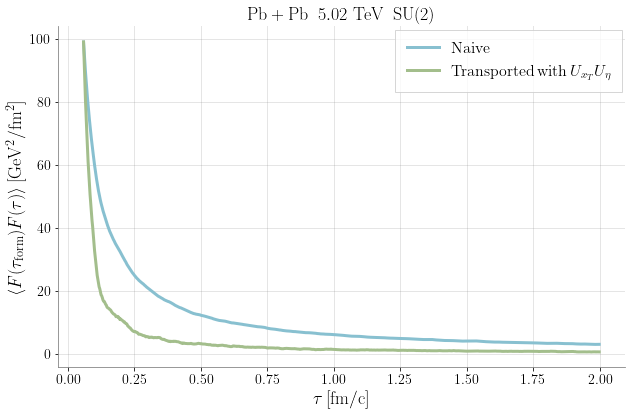

In [10]:
# tags_f = ['naive', 'UxUy', 'UxUyAeta', 'AetaUxUy']
tags_f = ['naive', 'UxUyAeta']

fig = plt.figure()
ax = plt.subplot(111)
plt.title(r'$\mathrm{Pb+Pb}\,\,\, 5.02\,\,\mathrm{TeV}\,\,\,\mathrm{SU(2)}$', size = 18)
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 18)
plt.ylabel(r'$\langle F(\tau_\mathrm{form})F(\tau)\rangle\,\mathrm{[GeV^2/fm^2]}$', size = 18)

# ax.xaxis.set_major_locator(MultipleLocator(0.5))
# ax.xaxis.set_minor_locator(MultipleLocator(0.25))
# ax.yaxis.set_major_locator(MultipleLocator(80))
# ax.yaxis.set_minor_locator(MultipleLocator(40))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
# ax.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
# ax.yaxis.get_major_ticks()[0].label1.set_visible(False)

plt.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)

# colors = [ '#88C0D0', '#A3BE8C', '#EBCB8B', '#B48EAD']
# labels = [r'$\mathrm{Naive}$', r'$\mathrm{Transported\,with\,}U_{x_T}$', r'$\mathrm{Transported\,with\,}U_{x_T}U_\eta$', r'$\mathrm{Transported\,with\,}U_\eta U_{x_T}$']

colors = [ '#88C0D0', '#A3BE8C']
labels = [ r'$\mathrm{Naive}$', r'$\mathrm{Transported\,with\,}U_{x_T}U_\eta$']

i = 0
sum_mean_FformF, sum_std_FformF = {}, {}
for tag in tags_f:
    sum_mean_FformF[tag] = mean_FformF[tag][:, 0, 0] + mean_FformF[tag][:, 1, 1] + mean_FformF[tag][:, 2, 2]
    sum_std_FformF[tag] = std_FformF[tag][:, 0, 0] + std_FformF[tag][:, 1, 1] + std_FformF[tag][:, 2, 2]
    ax.plot(tau[1:len(tau)], sum_mean_FformF[tag], linestyle = 'solid', color = colors[i], markersize = 0, linewidth = 3, label = labels[i])
    # ax.fill_between(tau[1:len(tau)], sum_mean_FformF[tag]-sum_std_FformF[tag]/2, sum_mean_FformF[tag]+sum_std_FformF[tag]/2, color = colors[i], alpha=0.3)
    i = i+1

leg = ax.legend(fontsize = 16, loc = 'upper right')
leg.get_frame().set_boxstyle('square')
# leg.set_title(r'$\tau_\mathrm{form}\,\mathrm{[fm/c]}$',prop={'size':18})

plt.tight_layout()
os.chdir(current_path)
plt.savefig('corr_FF_' + su_group + '_pT_' + str(pT) +'_pb+pb_5020gev.png', dpi=300, facecolor='white', transparent=False)
plt.show()

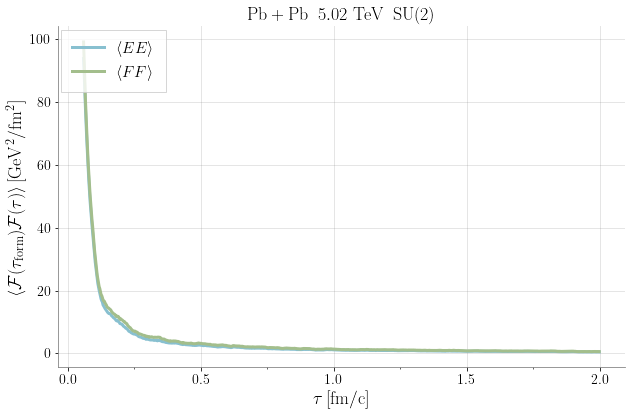

In [13]:
fig = plt.figure()
ax = plt.subplot(111)
plt.title(r'$\mathrm{Pb+Pb}\,\,\, 5.02\,\,\mathrm{TeV}\,\,\,\mathrm{SU(2)}$', size = 18)
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 18)
plt.ylabel(r'$\langle \mathcal{F}(\tau_\mathrm{form})\mathcal{F}(\tau)\rangle\,\mathrm{[GeV^2/fm^2]}$', size = 18)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
# ax.yaxis.set_major_locator(MultipleLocator(80))
# ax.yaxis.set_minor_locator(MultipleLocator(40))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 

plt.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)
tag = 'UxUyAeta'

ax.plot(tau[1:len(tau)], mean_EformE[tag][:, 0, 0] + mean_EformE[tag][:, 1, 1] + mean_EformE[tag][:, 2, 2], linestyle = 'solid', color = '#88C0D0', markersize = 0, linewidth = 3, label = r'$\langle EE\rangle$')
ax.plot(tau[1:len(tau)], mean_FformF[tag][:, 0, 0] + mean_FformF[tag][:, 1, 1] + mean_FformF[tag][:, 2, 2], linestyle = 'solid', color = '#A3BE8C', markersize = 0, linewidth = 3, label = r'$\langle FF\rangle$')


leg = ax.legend(fontsize = 16, loc = 'upper left')
leg.get_frame().set_boxstyle('square')
# leg.set_title(r'$\mathrm{Transported\,with\,}U_{x_T}$',prop={'size':12})

plt.tight_layout()
os.chdir(current_path)
plt.savefig('corr_comp_' + su_group + '_pT_' + str(pT) +'_pb+pb_5020gev.png', dpi=300, facecolor='white', transparent=False)
plt.show()

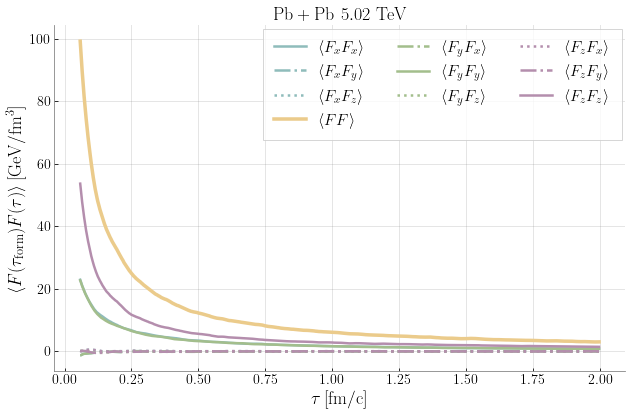

In [15]:
plt.figure()
plt.title(r'$\mathrm{Pb+Pb\,\,5.02\,\,TeV}$', size = 18)
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 18)
plt.ylabel(r'$\Big\langle F(\tau_\mathrm{form})F(\tau)\Big\rangle\,\mathrm{[GeV/fm^3]}$', size = 18)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
ax.tick_params(direction='in', grid_color='gray', grid_alpha=0.5)
plt.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)

colors = ['#8FBCBB', '#A3BE8C', '#B48EAD', '#EBCB8B']

tag = 'naive'

plt.plot(tau[1:len(tau)], mean_FformF[tag][:, 0, 0], '-', color = colors[0], markersize = 0, linewidth = 2.5, label = r'$\langle F_xF_x\rangle$', linestyle='solid')
plt.plot(tau[1:len(tau)], mean_FformF[tag][:, 0, 1], '-', color = colors[0], markersize = 0, linewidth = 2.5, label = r'$\langle F_xF_y\rangle$', linestyle='dashdot')
plt.plot(tau[1:len(tau)], mean_FformF[tag][:, 0, 2], '-', color = colors[0], markersize = 0, linewidth = 2.5, label = r'$\langle F_xF_z\rangle$', linestyle='dotted')

plt.plot(tau[1:len(tau)], mean_FformF[tag][:, 0, 0]+mean_FformF[tag][:, 1, 1]+mean_FformF[tag][:, 2, 2], '-', color = colors[3], markersize = 0, linewidth = 3.5, label = r'$\langle FF\rangle$', linestyle='solid')

plt.plot(tau[1:len(tau)], mean_FformF[tag][:, 1, 0], '-', color = colors[1], markersize = 0, linewidth = 2.5, label = r'$\langle F_yF_x\rangle$', linestyle='dashdot')
plt.plot(tau[1:len(tau)], mean_FformF[tag][:, 1, 1], '-', color = colors[1], markersize = 0, linewidth = 2.5, label = r'$\langle F_yF_y\rangle$', linestyle='solid')
plt.plot(tau[1:len(tau)], mean_FformF[tag][:, 1, 2], '-', color = colors[1], markersize = 0, linewidth = 2.5, label = r'$\langle F_yF_z\rangle$', linestyle='dotted')

plt.plot(tau[1:len(tau)], mean_FformF[tag][:, 2, 0], '-', color = colors[2], markersize = 0, linewidth = 2.5, label = r'$\langle F_zF_x\rangle$', linestyle='dotted')
plt.plot(tau[1:len(tau)], mean_FformF[tag][:, 2, 1], '-', color = colors[2], markersize = 0, linewidth = 2.5, label = r'$\langle F_zF_y\rangle$', linestyle='dashdot')
plt.plot(tau[1:len(tau)], mean_FformF[tag][:, 2, 2], '-', color = colors[2], markersize = 0, linewidth = 2.5, label = r'$\langle F_zF_z\rangle$', linestyle='solid')


leg = ax.legend(fontsize = 16, loc = 'upper right', ncol=3)
leg.get_frame().set_boxstyle('square')
# leg.set_title(r'$\tau_\mathrm{form}\,\mathrm{[fm/c]}$',prop={'size':18})

plt.tight_layout()
os.chdir(current_path)
plt.savefig('corr_FF_components_' + su_group + '_pT_' + str(pT) +'_pb+pb_5020gev.png', dpi=300, facecolor='white', transparent=False)
plt.show()